# a noise image has low probability

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns


/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor(),
)

In [3]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28]) torch.float32
Shape of y: torch.Size([128]) torch.int64


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
encoder = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 512),
  nn.Tanh(),
  nn.Linear(512, 512),
  nn.Tanh(),
  nn.Linear(512, 4),
)

decoder = nn.Sequential(
  nn.Linear(2, 512),
  nn.Tanh(),
  nn.Linear(512, 512),
  nn.Tanh(),
  nn.Linear(512, 784),
  nn.Sigmoid(),
  nn.Unflatten(1, [1, 28, 28])
)

model = nn.Sequential(OrderedDict([
          ('encoder', encoder),
          ('decoder', decoder),
        ])).to(device)

optimizer = torch.optim.Adam(model.parameters())

In [6]:
def train(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()
    loss = -likelihood + kld

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [7]:
model.to(device)
hist = torch.zeros(0)
for _ in range(20):
  tmp = train(model, train_dataloader, optimizer)
  hist = torch.cat([hist, tmp])

<AxesSubplot:xlabel='x', ylabel='y'>

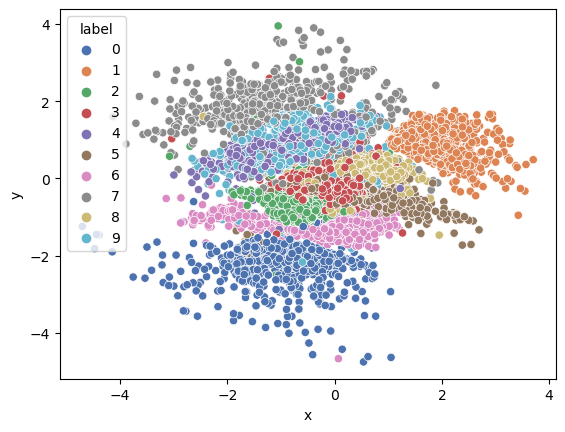

In [8]:
df = pd.DataFrame(columns=['x', 'y', 'label'])

model.to('cpu')

idx = 0
for X, y in test_dataloader:
  h = model.get_submodule('encoder')(X)
  mu = h[:, :2].detach().numpy()
  
  tmp = pd.DataFrame(
    {
      'x': mu[:, 0],
      'y': mu[:, 1],
      'label': y
    }
  )
  df = pd.concat([df, tmp], ignore_index=True)

  idx += 1
  if idx > 50:
    break

sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

In [11]:
noise = torch.rand(10, 1, 28, 28)
with torch.no_grad():
  z = model.get_submodule('encoder')(noise)
  print(z)

tensor([[-0.7233, -0.3908, -3.3807, -3.7646],
        [-0.7460, -0.4137, -3.3494, -3.7439],
        [-0.8458, -0.3218, -3.5140, -3.7103],
        [-0.8532, -0.4097, -3.4276, -3.6851],
        [-0.6428, -0.3931, -3.3873, -3.7990],
        [-0.5818, -0.4466, -3.3736, -3.7748],
        [-0.6524, -0.4282, -3.3355, -3.7807],
        [-0.8273, -0.4041, -3.4753, -3.7791],
        [-0.7534, -0.4460, -3.4002, -3.7388],
        [-0.6543, -0.4328, -3.3563, -3.8441]])
